<a href="https://colab.research.google.com/github/sagorbrur/bangla-bert/blob/master/notebook/bangla_bert_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [162]:
# !/usr/bin/python3.9 -m pip install seaborn

In [187]:
import pathlib
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
import csv
import pandas as pd
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Embedding
# from tensorflow.keras.callbacks import CSVLogger
# from tensorflow.keras.layers import GRU
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
# import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import pickle
from sklearn.model_selection import KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn import preprocessing
# import gensim as gensim
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
# from tensorflow.keras.models import Sequential
from sklearn.model_selection import GridSearchCV


In [188]:
import pandas as pd
dataset_url = 'https://raw.githubusercontent.com/supreme-lab/gender-identification/main/dataset.csv'

df = pd.read_csv(dataset_url)
df = df.dropna(subset=['text', 'gender'])
df.head()

,text,gender
0,ল্যাবে গ্রুপমেটের গ্রাফ নিজে একে দিয়েছি অনেক ...,M
1,"এরকম এক রমজান মাসের স্নিগ্ধ বিকেলে, জনৈক বুয়েট...",M
2,শিবিরবিহীন বুয়েট থেকে শিবিরের কেন্দ্রীয় কমিটির...,M
3,জনৈক বন্ধু তার বান্ধবীর সাথে দেখা করার আগে নিজ...,M
4,খুব ক্লোজ জুনিয়রের সাথে শেরে বাংলা হলের সামনের...,M


In [189]:
df.index.size

15367

In [190]:
def get_male_female_keywords(posts, genders):
  # compute keyword for male and female samples
  male_keywords = []
  female_keywords = []
  for idx, post in enumerate(posts):
    splitted = post.split()
    if genders[idx] == "M":
      male_keywords.extend(splitted)
    else:
      female_keywords.extend(splitted)
  return male_keywords, female_keywords

In [191]:
def get_frequency_from_list(keywords):
  freq = {}
  for word in keywords:
    if word in freq:
      freq[word] = freq[word] + 1
    else:
      freq[word] = 1
  return freq

In [192]:
import numpy as np
import pathlib
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.linear_model import SGDClassifier
import random
from sklearn.feature_selection import SelectKBest, chi2

class DataPreProcessor(object):
  def __init__(self, dataset_url):
    self.dataset_url = dataset_url

  def preprocess(self):
    # stop word list
    stop_word_file = 'https://raw.githubusercontent.com/supreme-lab/gender-identification/main/stopwords-bn.txt'
    sw_df = pd.read_csv(stop_word_file, delimiter="\t", header=None)
    stopword_list = sw_df.values.tolist()

    # load the training data
    df = pd.read_csv(self.dataset_url)

    # preprocess step 0: remove duplicate rows
    df = df.drop_duplicates()
    print("after removing duplicate rows, row count: ", df.index.size)

    # preprocess step 1: remove null rows
    df = df.dropna(subset=['text', 'gender'])
    print("after removing null rows, row count: ", df.index.size)

    # preprocess step 2: remove non Bangla characters
    author_posts = []
    author_genders = []
    for index, row in df.iterrows():
        tokens = [re.sub(r'[^\u0980-\u09FF ]+', ' ', str(row['text']))]
        tokens_joined = " ".join(tokens)
        if len(tokens_joined) == 0:
          print("tokens_joined.len==0")
        author_posts.append(tokens_joined)
        author_genders.append(row['gender'])

    stopword_list_new = []
    for word in stopword_list:
      stopword_list_new.append(word[0])
    stopword_list = stopword_list_new
    # preprocess step 3: remove stop words
    author_posts_without_stopword = []
    author_genders_without_stopword = []
    i = 0
    for idx, post in enumerate(author_posts):
        i = i + 1
        # if i< 100:
        #   print("before stopword removal sent.len: ", len(post.split()))
        tokens_without_stopword = [word for word in post.split() if not word in stopword_list]
         

        if ('দেখেছি' in tokens_without_stopword or 'গ্রেড' in tokens_without_stopword or 'অনলাইন' in tokens_without_stopword or 'পাবলিক' in tokens_without_stopword or
        'পাপী' in tokens_without_stopword or 'ফিস্ট' in tokens_without_stopword) and len(tokens_without_stopword) < 5:
          print("post: ", post)
          print("tokens_without_stopword: ", tokens_without_stopword)
          
        # if i<100:
        #   print("after stopword removal sent.len: ", len(tokens_without_stopword))
        tokens_without_stopword_joined = " ".join(tokens_without_stopword)
        if len(tokens_without_stopword_joined) > 0:
          # print("tokens_without_stopword_joined: ", tokens_without_stopword_joined)
          # print("len(tokens_without_stopword_joined) == 0")
          author_posts_without_stopword.append(tokens_without_stopword_joined)
          author_genders_without_stopword.append(author_genders[idx])
    
    post_count = len(author_posts_without_stopword)
    gender_count = len(author_genders_without_stopword)

    print(f"after stopword removing posts.len: {post_count}, gender.count: {gender_count}")
    print("author_genders_without_stopword[0:10]")
    print(author_genders_without_stopword[0:10])

    malekeywords, femalekeywords = get_male_female_keywords(author_posts_without_stopword, author_genders)
    
    # compute keyword occurrence in male and female data
    # print("compute keyword occurrence in male and female data")
    male_freq = get_frequency_from_list(malekeywords)
    female_freq = get_frequency_from_list(femalekeywords)

    # filter out keywords with occurrence <10
    # print("filter out keywords with occurrence <10 ")
    features = []
    for key, value in male_freq.items():
      if value >= 10:
        features.append(key)

    for key, value in female_freq.items():
      if value >= 10:
        features.append(key)

    # get the unique keywords
    # print("get the unique keywords")
    featureset = set(features)
    # print("featureset.len: ", len(featureset))

    # keep words which are in the featureset
    # print("keep words which are in the featureset")
    i = 0
    author_posts_with_keywords_in_features = []
    author_genders_with_keywords_in_features = []
    for idx, post in enumerate(author_posts_without_stopword):
        # if i < 100:
        #   print("post.len: ", len(post.split()))
        tokens_filtered_with_features = [word for word in post.split() if word in featureset]
        tokens_filtered_with_features_joined = " ".join(tokens_filtered_with_features)
        # if i<100:
        #   print("tokens_without_keywords_with_occurrence1.len: ", len(tokens_without_keywords_with_occurrence1))
        
        if len(tokens_filtered_with_features_joined) > 0:
          # print("len(tokens_filtered_with_features_joined) == 0")
          author_posts_with_keywords_in_features.append(tokens_filtered_with_features_joined)
          author_genders_with_keywords_in_features.append(author_genders_without_stopword[idx])
    
    post_count = len(author_posts_with_keywords_in_features)
    gender_count = len(author_genders_with_keywords_in_features)

    print(f"after removing out of features posts.len: {post_count}, gender.count: {gender_count}")
    print("author_genders_with_keywords_in_features[0:10]: ", author_genders_with_keywords_in_features[0:10])

    return author_posts_with_keywords_in_features, author_genders_with_keywords_in_features

In [193]:
dataset_url = "https://raw.githubusercontent.com/supreme-lab/gender-identification/main/dataset.csv"
preprocessor = DataPreProcessor(dataset_url)
posts, genders = preprocessor.preprocess()

after removing duplicate rows, row count:  12726
after removing null rows, row count:  12726
post:  কিছু মানুষকে সব মেয়ে   এ থাকতে দেখেছি         
tokens_without_stopword:  ['মানুষকে', 'মেয়ে', 'থাকতে', 'দেখেছি']
post:  অনলাইন ক্লাসের রুটিন         
tokens_without_stopword:  ['অনলাইন', 'ক্লাসের', 'রুটিন']
post:    এ     নিয়ে  এটা দিয়ে কি হবে ধেস  বলতে দেখেছি          
tokens_without_stopword:  ['দিয়ে', 'ধেস', 'দেখেছি']
post:  জুনিয়রের কাছে চোথা বিক্রি করতে দেখেছি         
tokens_without_stopword:  ['জুনিয়রের', 'চোথা', 'বিক্রি', 'দেখেছি']
post:      এ ছাত্রলীগের স্টল দেখেছি         
tokens_without_stopword:  ['ছাত্রলীগের', 'স্টল', 'দেখেছি']
post:  নতুন   কে ভুলে ভাই বলে ডাকতে দেখেছি         
tokens_without_stopword:  ['ভুলে', 'ভাই', 'ডাকতে', 'দেখেছি']
post:  পাপী         
tokens_without_stopword:  ['পাপী']
post:  পলাশীর সেই চাইনিজ হারিয়ে যেতে দেখেছি         
tokens_without_stopword:  ['পলাশীর', 'চাইনিজ', 'হারিয়ে', 'দেখেছি']
post:  রুমমেট কে ২০২০ এ এসে প্রথমবার     দেখতে দেখেছি         
t

In [194]:
len(posts), len(genders)

(10397, 10397)

In [195]:
mgs = len([g for g in genders if g == "M"])
fgs = len([g for g in genders if g == "F"])
("male: ", (100*mgs/(mgs+fgs))), ("female: ", (100*fgs/(mgs+fgs)))

(('male: ', 60.8925651630278), ('female: ', 39.1074348369722))

In [196]:
count0 = count1 = count2 = count3 = count4 = count5 = countgreater5less10 = countgreater10lessequal20 = countgreater20lessequal30 = countgreater30lessequal40 = countgreater40lessequal50 = countgreater50lessequal60 = countgreater60lessequal70 = countgreater70lessequal80 = countgreater80lessequal90 = countgreater90lessequal100 = countgreater100lessequal150 = countgreater150lessequal200 = countgreater200lessequal250 = countgreater250lessequal300 = countgreater300lessequal350 = countgreater350less400 = countgreater400less450 = countgreater450less500 = countgreater500 = 0

for idx, post in enumerate(posts):
  strs = post.split()
  count0 = count0 + 1 if len(strs) == 0 else count0
  count1 = count1 + 1 if len(strs) == 1 else count1
  if count1 < 10 and len(strs) == 1:
    print("strs.len==1: ", strs)
  count2 = count2 + 1 if len(strs) == 2 else count2
  if count2 < 10 and len(strs) == 2:
    print("strslen==2: ", strs)
  count3 = count3 + 1 if len(strs) == 3 else count3
  if count2 < 10 and len(strs) == 3:
    print("strslen==3: ", strs)
  count4 = count4 + 1 if len(strs) == 4 else count4
  count5 = count5 + 1 if len(strs) == 5 else count5
  countgreater5less10 = countgreater5less10 + 1 if len(strs)>5 and len(strs) <=10 else countgreater5less10
  countgreater10lessequal20 = countgreater10lessequal20 + 1 if len(strs)>10 and len(strs)<=20 else countgreater10lessequal20
  countgreater20lessequal30 = countgreater20lessequal30 + 1 if len(strs)>20 and len(strs)<=30 else countgreater20lessequal30
  countgreater30lessequal40 = countgreater30lessequal40 + 1 if len(strs)>30 and len(strs)<=40 else countgreater30lessequal40
  countgreater40lessequal50 = countgreater40lessequal50 + 1 if len(strs)>40 and len(strs)<=50 else countgreater40lessequal50
  countgreater50lessequal60 = countgreater50lessequal60 + 1 if len(strs)>50 and len(strs)<=60 else countgreater50lessequal60
  countgreater60lessequal70 = countgreater60lessequal70 + 1 if len(strs)>60 and len(strs)<=70 else countgreater60lessequal70
  countgreater70lessequal80 = countgreater70lessequal80 + 1 if len(strs)>70 and len(strs)<=80 else countgreater70lessequal80
  countgreater80lessequal90 = countgreater80lessequal90 + 1 if len(strs)>80 and len(strs)<=90 else countgreater80lessequal90
  countgreater90lessequal100 = countgreater90lessequal100 + 1 if len(strs)>90 and len(strs)<=100 else countgreater90lessequal100
  countgreater100lessequal150 = countgreater100lessequal150 + 1 if len(strs)>100 and len(strs)<=150 else countgreater100lessequal150
  countgreater150lessequal200 = countgreater150lessequal200 + 1 if len(strs)>150 and len(strs)<=200 else countgreater150lessequal200
  countgreater200lessequal250 = countgreater200lessequal250 + 1 if len(strs)>200 and len(strs)<=250 else countgreater200lessequal250
  countgreater250lessequal300 = countgreater250lessequal300 + 1 if len(strs)>250 and len(strs)<=300 else countgreater250lessequal300
  countgreater300lessequal350 = countgreater300lessequal350 + 1 if len(strs)>300 and len(strs)<=350 else countgreater300lessequal350
  countgreater350less400 = countgreater350less400 + 1 if len(strs)>350 and len(strs)<=400 else countgreater350less400
  countgreater400less450 = countgreater400less450 + 1 if len(strs)>400 and len(strs)<=450 else countgreater400less450
  countgreater450less500 = countgreater450less500 + 1 if len(strs)>450 and len(strs)<=500 else countgreater450less500
  countgreater500 = countgreater500 + 1 if len(strs)>500 else countgreater500

total_count = count0 + count1 + count2 + count3 + count4 + count5 + countgreater5less10 + countgreater10lessequal20 + countgreater20lessequal30 + countgreater30lessequal40 + countgreater40lessequal50 + countgreater50lessequal60 + countgreater60lessequal70 + countgreater70lessequal80 + countgreater80lessequal90 + countgreater90lessequal100 + countgreater100lessequal150 + countgreater150lessequal200 + countgreater200lessequal250 + countgreater250lessequal300 + countgreater300lessequal350 + countgreater350less400 + countgreater400less450 + countgreater450less500 + countgreater500
print("total_count: ", total_count)

strs.len==1:  ['দেখেছি']
strslen==3:  ['গ্রেড', 'আসা', 'দেখেছি']
strslen==3:  ['অনলাইন', 'ক্লাসের', 'রুটিন']
strslen==2:  ['দিয়ে', 'দেখেছি']
strslen==3:  ['এক', 'একসাথে', 'দেখেছি']
strslen==2:  ['হলের', 'দেখছি']
strslen==3:  ['লেখা', 'গান', 'দেখেছি']
strslen==3:  ['পড়ে', 'ক্লাস', 'দেখেছি']
strslen==3:  ['পাবলিক', 'অভাবে', 'ভদ্র']
strslen==3:  ['ছাত্রলীগের', 'স্টল', 'দেখেছি']
strslen==3:  ['ট্যুরে', 'এভাবে', 'দেখেছি']
strslen==3:  ['রাত', 'পড়তে', 'দেখেছি']
strslen==3:  ['বুয়েটে', 'শুনতাম', 'উন্নয়ন']
strslen==3:  ['নেট', 'ল্যাবের', 'দেখছি']
strs.len==1:  ['পাপী']
strslen==3:  ['পলাশীর', 'হারিয়ে', 'দেখেছি']
strslen==3:  ['অনলাইন', 'ক্লাসে', 'শুনেছি']
strslen==3:  ['গ্রুপের', 'জানি', 'লাগতেছে']
strslen==2:  ['বাণী', 'ক্রেডিট']
strs.len==1:  ['দেখেছি']
strslen==2:  ['অপরাধে', 'শুনেছি']
strslen==3:  ['অনলাইন', 'ক্লাসে', 'শুনেছি']
strslen==3:  ['চৌধুরী', 'গ্রুপের', 'দেখেছি']
strslen==3:  ['পাপী', 'চোখে', 'দেখেছি']
strslen==2:  ['ফিস্ট', 'দেখেছি']
strs.len==1:  ['দেখেছি']
strslen==3:  ['ডাইনিং

In [173]:
# !/usr/bin/python3.9 -m pip install matplotlib

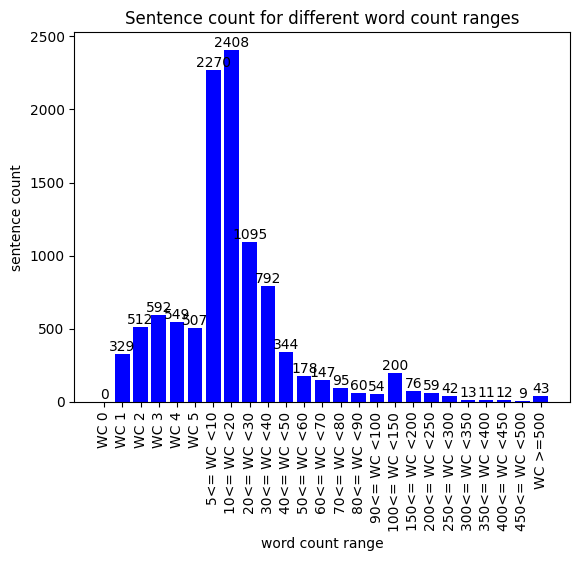

In [198]:
import matplotlib.pyplot as plt

y_axis_values = [
    count0, count1, count2, count3, count4, count5,
    countgreater5less10, countgreater10lessequal20, countgreater20lessequal30, countgreater30lessequal40, countgreater40lessequal50,
    countgreater50lessequal60, countgreater60lessequal70, countgreater70lessequal80, countgreater80lessequal90, countgreater90lessequal100,
    countgreater100lessequal150, countgreater150lessequal200, countgreater200lessequal250, countgreater250lessequal300, countgreater300lessequal350,
    countgreater350less400, countgreater400less450, countgreater450less500, countgreater500
    ]
x_axis_values = [
    "words 0", "words 1", "words 2", "words 3", "words 4", "words 5", "words >=5 and < 10", "words >= 10 and < 20", "words >= 20 and < 30", "words >= 30 and < 40", "words >= 40 and < 50",
    "words >=50 and < 60", "words >= 60 and < 70", "words >= 70 and < 80", "words >= 80 and < 90", "words >= 90 and < 100", "words >= 100 and < 150",
    "words >= 150 and < 200", "words >= 200 and < 250", "words >= 250 and < 300", "words >= 300 and < 350", "words >= 350 and < 400", "words >= 400 and < 450",
    "words >= 450 and < 500", "words >= 500"
]

x_axis_values = [
    "WC 0", "WC 1", "WC 2", "WC 3", "WC 4", "WC 5", "5<= WC <10", "10<= WC <20", "20<= WC <30", "30<= WC <40", "40<= WC <50",
    "50<= WC <60", "60<= WC <70", "70<= WC <80", "80<= WC <90", "90<= WC <100", "100<= WC <150",
    "150<= WC <200", "200<= WC <250", "250<= WC <300", "300<= WC <350", "350<= WC <400", "400<= WC <450",
    "450<= WC <500", "WC >=500"
]

# Create a bar chart
plt.bar(x_axis_values, y_axis_values, color='blue')

# Adding labels and title
plt.xlabel('word count range')
plt.ylabel('sentence count')
plt.title('Sentence count for different word count ranges')

# Adding values on top of the bars
for i, v in enumerate(y_axis_values):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom')

# Rotate x-axis tick labels vertically
plt.xticks(rotation='vertical')

# Show the bar chart
plt.show()


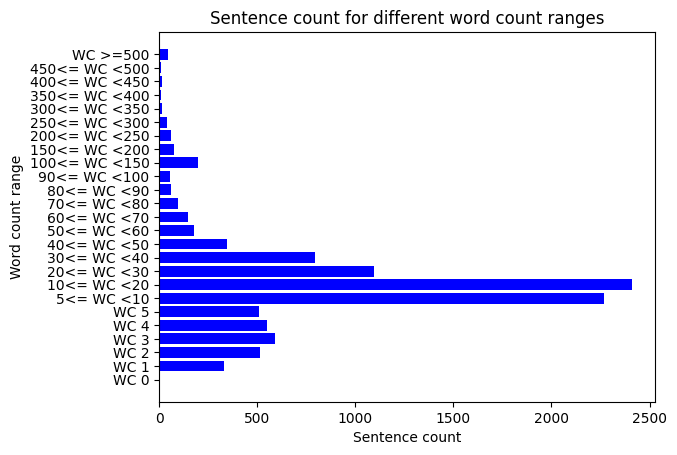

In [199]:
plt.barh(x_axis_values, y_axis_values, color='blue')
plt.xlabel('Sentence count')
plt.ylabel('Word count range')
plt.title('Sentence count for different word count ranges')
plt.show()

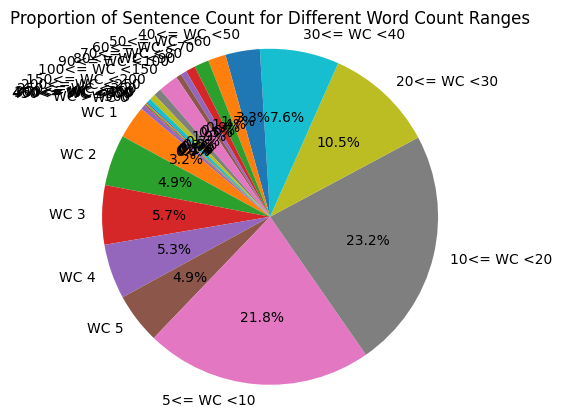

In [200]:
plt.pie(y_axis_values, labels=x_axis_values, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Proportion of Sentence Count for Different Word Count Ranges')
plt.show()

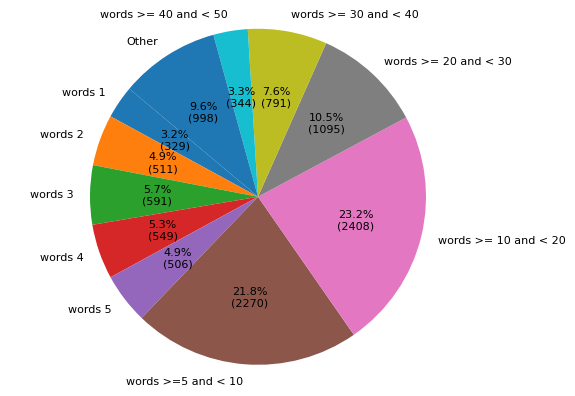

In [201]:
import matplotlib.pyplot as plt

# Data
y_axis_values = [
    count0, count1, count2, count3, count4, count5,
    countgreater5less10, countgreater10lessequal20, countgreater20lessequal30, countgreater30lessequal40, countgreater40lessequal50,
    countgreater50lessequal60, countgreater60lessequal70, countgreater70lessequal80, countgreater80lessequal90, countgreater90lessequal100,
    countgreater100lessequal150, countgreater150lessequal200, countgreater200lessequal250, countgreater250lessequal300, countgreater300lessequal350,
    countgreater350less400, countgreater400less450, countgreater450less500, countgreater500
]
x_axis_values = [
    "words 0", "words 1", "words 2", "words 3", "words 4", "words 5", "words >=5 and < 10", "words >= 10 and < 20", "words >= 20 and < 30", "words >= 30 and < 40", "words >= 40 and < 50",
    "words >=50 and < 60", "words >= 60 and < 70", "words >= 70 and < 80", "words >= 80 and < 90", "words >= 90 and < 100", "words >= 100 and < 150",
    "words >= 150 and < 200", "words >= 200 and < 250", "words >= 250 and < 300", "words >= 300 and < 350", "words >= 350 and < 400", "words >= 400 and < 450",
    "words >= 450 and < 500", "words >= 500"
]

# Threshold for merging categories with less than 5% contribution
threshold_percentage = 3

# Preprocess data to merge values less than 5%
total_count = sum(y_axis_values)
merged_values = []
merged_labels = []
other_count = 0

for count, label in zip(y_axis_values, x_axis_values):
    percentage = (count / total_count) * 100
    if percentage < threshold_percentage:
        other_count += count
    else:
        merged_values.append(count)
        merged_labels.append(label)

# Add 'Other' category
if other_count > 0:
    merged_values.append(other_count)
    merged_labels.append('Other')

# Plot
fig, ax = plt.subplots()
wedges, labels, autopct = ax.pie(merged_values, labels=merged_labels, autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100*total_count)})', startangle=140, textprops={'fontsize': 8})

# Title
# plt.title('Proportion and Count of Sentence for Different Word Count Ranges', fontsize=12)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')

# Show plot
plt.show()


### keep posts which length between 5 and 300

In [175]:
posts_new = []
genders_new = []
for idx, post in enumerate(posts):
  strs = post.split()
  if len(strs) >=5 and len(strs)<=300:
    posts_new.append(post)
    genders_new.append(genders[idx])

("posts_new.len: ", len(posts_new)), ("genders_new.len: ", len(genders_new))

(('posts_new.len: ', 8327), ('genders_new.len: ', 8327))

In [176]:
mgs = len([g for g in genders_new if g == "M"])
fgs = len([g for g in genders_new if g == "F"])
("male: ", (100*mgs/(mgs+fgs))), ("female: ", (100*fgs/(mgs+fgs)))

(('male: ', 62.7596973700012), ('female: ', 37.2403026299988))

In [177]:
posts = posts_new
genders = genders_new

In [178]:
len(posts), len(genders)

(8327, 8327)

### ModelTraditional with TFIDF feature

In [179]:
from sklearn.model_selection import GridSearchCV
class ModelTraditionalWithTFIDF():
  def __init__(self, posts, genders, model_name) -> None:
    self.author_posts = posts
    self.author_genders = genders
    self.model_name = model_name
    self.model = None

  def train(self):
    label_encoder = LabelEncoder()
    label_encoder.fit(self.author_genders)
    labels = label_encoder.transform(self.author_genders)

    train_x, test_x, train_y, test_y = model_selection.train_test_split(self.author_posts, labels, test_size=0.2)

    male_list = []
    female_list = []

    self.tfidf_vectorizer = TfidfVectorizer(max_features=1000, analyzer='word', ngram_range=(1, 3))
    self.tfidf_vectorizer.fit(self.author_posts)

    vocabs = self.tfidf_vectorizer.get_feature_names_out()

    train_x_tfidf = self.tfidf_vectorizer.transform(train_x)
    test_x_tfidf = self.tfidf_vectorizer.transform(test_x)

    model = None
    if self.model_name == "SGD":
      sgdc = SGDClassifier()

      sgdc_params = {
          'loss':['hinge', 'log_loss'],
          'penalty':['elasticnet'],
          'max_iter':[1000],
          'alpha':np.logspace(-4, 4, 10),
          'l1_ratio':[0.05,0.06,0.07],
          'tol': [0.01]
      }

      sgdc_gs = GridSearchCV(sgdc, sgdc_params, cv=5, verbose=1, n_jobs=1)

      #Here I fit the model to my dataset
      sgdc_gs.fit(train_x_tfidf, train_y)
      author_gender_pred = sgdc_gs.predict(test_x_tfidf)

      accuracy = accuracy_score(test_y, author_gender_pred)
      precision = precision_score(test_y, author_gender_pred)
      recall = recall_score(test_y, author_gender_pred)
      f1 = f1_score(test_y, author_gender_pred)
      # model = SGDClassifier(max_iter=1000, tol=0.01)
    elif self.model_name == 'RF': 
      param_grid = {
          'n_estimators': [100, 200],
          'max_features': ['sqrt', 'log2'],
          'max_depth' : [2,4,5,6,7,8],
          'criterion' :['gini', 'entropy']
      }
      rfc = RandomForestClassifier(random_state=42)
      cv_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
      cv_rfc.fit(train_x_tfidf, train_y)
      author_gender_pred = cv_rfc.predict(test_x_tfidf)

      accuracy = accuracy_score(test_y, author_gender_pred)
      precision = precision_score(test_y, author_gender_pred)
      recall = recall_score(test_y, author_gender_pred)
      f1 = f1_score(test_y, author_gender_pred)
      # model = RandomForestClassifier(max_depth=2, random_state=0)
    elif self.model_name == 'NB': 
      # Create a pipeline with CountVectorizer and MultinomialNB
      model = MultinomialNB()

      # Define the parameter grid
      param_grid = {
          'alpha': [0.1, 0.5, 1.0],
      }

      # Create GridSearchCV
      cv_nb = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

      # Fit the grid search to the data
      cv_nb.fit(train_x_tfidf, train_y)
      author_gender_pred = cv_nb.predict(test_x_tfidf)

      accuracy = accuracy_score(test_y, author_gender_pred)
      precision = precision_score(test_y, author_gender_pred)
      recall = recall_score(test_y, author_gender_pred)
      f1 = f1_score(test_y, author_gender_pred)
      # model = MultinomialNB()
    elif self.model_name == 'SVM': 
      model = SVC(kernel='linear')
      model.fit(train_x_tfidf, train_y)
      author_gender_pred = model.predict(test_x_tfidf)

      accuracy = accuracy_score(test_y, author_gender_pred)
      precision = precision_score(test_y, author_gender_pred)
      recall = recall_score(test_y, author_gender_pred)
      f1 = f1_score(test_y, author_gender_pred)

    elif self.model_name == 'LR': 
      model = LogisticRegression(random_state=0)
      model.fit(train_x_tfidf, train_y)
      author_gender_pred = model.predict(test_x_tfidf)

      accuracy = accuracy_score(test_y, author_gender_pred)
      precision = precision_score(test_y, author_gender_pred)
      recall = recall_score(test_y, author_gender_pred)
      f1 = f1_score(test_y, author_gender_pred)

    elif self.model_name == 'DT': 
      model = DecisionTreeClassifier(random_state=0)
      model.fit(train_x_tfidf, train_y)
      author_gender_pred = model.predict(test_x_tfidf)

      accuracy = accuracy_score(test_y, author_gender_pred)
      precision = precision_score(test_y, author_gender_pred)
      recall = recall_score(test_y, author_gender_pred)
      f1 = f1_score(test_y, author_gender_pred)

    elif self.model_name == 'KNN': 
      model =  KNeighborsClassifier(n_neighbors=3)
      model.fit(train_x_tfidf, train_y)
      author_gender_pred = model.predict(test_x_tfidf)

      accuracy = accuracy_score(test_y, author_gender_pred)
      precision = precision_score(test_y, author_gender_pred)
      recall = recall_score(test_y, author_gender_pred)
      f1 = f1_score(test_y, author_gender_pred)

    return accuracy, precision, recall, f1

In [180]:
model = ModelTraditionalWithTFIDF(posts, genders, "SGD")
accuracy, precision, recall, f1 = model.train()
print("accuracy: ", accuracy)
print("precision: ", precision)
print("recall: ", recall)
print("f1: ", f1)

# word count 1 to 300 + preprocessing (all)
# accuracy:  0.6789524733268671
# precision:  0.7008959338387319
# recall:  0.8168674698795181
# f1:  0.7544510385756676

# word count 2 to 300 + preprocessing (all)
# accuracy:  0.7069138276553106
# precision:  0.7287671232876712
# recall:  0.8491620111731844
# f1:  0.784371544415776

# word count 3 to 300 + preprocessing (all)
# accuracy:  0.6884899683210137
# precision:  0.7219291635267521
# recall:  0.8125530110262935
# f1:  0.7645650438946529

# word count 4 to 300 + preprocessing (all)
# accuracy:  0.7032657657657657
# precision:  0.7228260869565217
# recall:  0.8455949137148048
# f1:  0.77940560904144

# word count 5 to 300 + preprocessing (all)
# accuracy:  0.7034813925570228
# precision:  0.7287581699346405
# recall:  0.8462998102466793
# f1:  0.7831431079894644

Fitting 5 folds for each of 60 candidates, totalling 300 fits
accuracy:  0.7034813925570228
precision:  0.7287581699346405
recall:  0.8462998102466793
f1:  0.7831431079894644


In [181]:
model = ModelTraditionalWithTFIDF(posts, genders, "RF")
accuracy, precision, recall, f1 = model.train()
print("accuracy: ", accuracy)
print("precision: ", precision)
print("recall: ", recall)
print("f1: ", f1)

# word count 1 to 300 + preprocessing (all)
# accuracy:  0.6319107662463628
# precision:  0.6266601082144614
# recall:  1.0
# f1:  0.7704868460840641

# word count 2 to 300 + preprocessing (all)
# accuracy:  0.6447895791583166
# precision:  0.6391015824400205
# recall:  0.9984051036682615
# f1:  0.779333955804544

# word count 3 to 300 + preprocessing (all)
# accuracy:  0.6541710665258712
# precision:  0.6491133799032778
# recall:  0.9983471074380166
# f1:  0.7867144252686421

# word count 4 to 300 + preprocessing (all)
# accuracy:  0.6323198198198198
# precision:  0.6267887807670292
# recall:  0.9990875912408759
# f1:  0.7703130495954977

# word count 5 to 300 + preprocessing (all)
# accuracy:  0.6266506602641057
# precision:  0.6211936662606578
# recall:  1.0
# f1:  0.7663410969196093

accuracy:  0.6266506602641057
precision:  0.6211936662606578
recall:  1.0
f1:  0.7663410969196093


In [182]:
model = ModelTraditionalWithTFIDF(posts, genders, "NB")
accuracy, precision, recall, f1 = model.train()
print("accuracy: ", accuracy)
print("precision: ", precision)
print("recall: ", recall)
print("f1: ", f1)

# word count 1 to 300 + preprocessing (all)
# accuracy:  0.6755577109602328
# precision:  0.6817891373801916
# recall:  0.8618739903069467
# f1:  0.7613271494826971

# word count 2 to 300 + preprocessing (all)
# accuracy:  0.6823647294589178
# precision:  0.6895657809462087
# recall:  0.8728465955701394
# f1:  0.7704561911658219

# word count 3 to 300 + preprocessing (all)
# accuracy:  0.6958817317845829
# precision:  0.7086776859504132
# recall:  0.8705583756345178
# f1:  0.7813211845102506

# word count 4 to 300 + preprocessing (all)
# accuracy:  0.696509009009009
# precision:  0.7017045454545454
# recall:  0.8925022583559169
# f1:  0.7856858846918489

# word count 5 to 300 + preprocessing (all)
# accuracy:  0.698079231692677
# precision:  0.7056603773584905
# recall:  0.892175572519084
# f1:  0.78803202697008

accuracy:  0.698079231692677
precision:  0.7056603773584905
recall:  0.892175572519084
f1:  0.78803202697008


In [183]:
model = ModelTraditionalWithTFIDF(posts, genders, "SVM")
accuracy, precision, recall, f1 = model.train()
print("accuracy: ", accuracy)
print("precision: ", precision)
print("recall: ", recall)
print("f1: ", f1)

# word count 1 to 300 + preprocessing (all)
# accuracy:  0.6847720659553831
# precision:  0.6951623591782637
# recall:  0.8466505246166263
# f1:  0.7634643377001455

# word count 2 to 300 + preprocessing (all)
# accuracy:  0.7084168336673347
# precision:  0.7433881343817013
# recall:  0.8234362628661916
# f1:  0.7813673929376409
# word count 3 to 300 + preprocessing (all)
# accuracy:  0.7111932418162619
# precision:  0.7288503253796096
# recall:  0.8542372881355932
# f1:  0.7865782286383145

# word count 4 to 300 + preprocessing (all)
# accuracy:  0.7043918918918919
# precision:  0.7320463320463321
# recall:  0.8419182948490231
# f1:  0.7831474597273854

# word count 5 to 300 + preprocessing (all)
# accuracy:  0.6956782713085234
# precision:  0.7307373653686827
# recall:  0.8289473684210527
# f1:  0.7767503302509907

accuracy:  0.6956782713085234
precision:  0.7307373653686827
recall:  0.8289473684210527
f1:  0.7767503302509907


In [184]:
model = ModelTraditionalWithTFIDF(posts, genders, "LR")
accuracy, precision, recall, f1 = model.train()
print("accuracy: ", accuracy)
print("precision: ", precision)
print("recall: ", recall)
print("f1: ", f1)

# word count 1 to 300 + preprocessing (all)
# accuracy:  0.6978661493695442
# precision:  0.718856364874064
# recall:  0.8341232227488151
# f1:  0.7722120658135283

# word count 2 to 300 + preprocessing (all)
# accuracy:  0.6998997995991983
# precision:  0.7127297481279782
# recall:  0.8553921568627451
# f1:  0.7775714816190122

# word count 3 to 300 + preprocessing (all)
# accuracy:  0.6816261879619853
# precision:  0.7028169014084507
# recall:  0.8464800678541137
# f1:  0.7679876875721431

# word count 4 to 300 + preprocessing (all)
# accuracy:  0.6897522522522522
# precision:  0.7109375
# recall:  0.8340971585701191
# f1:  0.7676086039645719

# word count 5 to 300 + preprocessing (all)
# accuracy:  0.709483793517407
# precision:  0.7344
# recall:  0.8579439252336448
# f1:  0.7913793103448276

accuracy:  0.709483793517407
precision:  0.7344
recall:  0.8579439252336448
f1:  0.7913793103448276


In [185]:
model = ModelTraditionalWithTFIDF(posts, genders, "DT")
accuracy, precision, recall, f1 = model.train()
print("accuracy: ", accuracy)
print("precision: ", precision)
print("recall: ", recall)
print("f1: ", f1)

# word count 1 to 300 + preprocessing (all)
# accuracy:  0.6256062075654704
# precision:  0.6959016393442623
# recall:  0.6792
# f1:  0.6874493927125506

# word count 2 to 300 + preprocessing (all)
# accuracy:  0.6052104208416834
# precision:  0.699581589958159
# recall:  0.6608695652173913
# f1:  0.6796747967479675

# word count 3 to 300 + preprocessing (all)
# accuracy:  0.6282998944033791
# precision:  0.6980976013234078
# recall:  0.7134404057480981
# f1:  0.705685618729097

# word count 4 to 300 + preprocessing (all)
# accuracy:  0.6188063063063063
# precision:  0.6974716652136007
# recall:  0.7079646017699115
# f1:  0.7026789635485288

# word count 5 to 300 + preprocessing (all)
# accuracy:  0.6446578631452581
# precision:  0.7236467236467237
# recall:  0.7168391345249294
# f1:  0.720226843100189

accuracy:  0.6446578631452581
precision:  0.7236467236467237
recall:  0.7168391345249294
f1:  0.720226843100189


In [186]:
model = ModelTraditionalWithTFIDF(posts, genders, "KNN")
accuracy, precision, recall, f1 = model.train()
print("accuracy: ", accuracy)
print("precision: ", precision)
print("recall: ", recall)
print("f1: ", f1)

# word count 1 to 300 + preprocessing (all)
# accuracy:  0.6018428709990301
# precision:  0.72782874617737
# recall:  0.5630914826498423
# f1:  0.634948866162739

# word count 2 to 300 + preprocessing (all)
# accuracy:  0.5516032064128257
# precision:  0.6973684210526315
# recall:  0.47591836734693876
# f1:  0.5657447840853954

# word count 3 to 300 + preprocessing (all)
# accuracy:  0.558078141499472
# precision:  0.7184343434343434
# recall:  0.4809805579036348
# f1:  0.5762025316455697

# word count 4 to 300 + preprocessing (all)
# accuracy:  0.651463963963964
# precision:  0.6773519163763067
# recall:  0.8617021276595744
# f1:  0.758486149044089

# word count 5 to 300 + preprocessing (all)
# accuracy:  0.6326530612244898
# precision:  0.6457883369330454
# recall:  0.8820058997050148
# f1:  0.7456359102244389

accuracy:  0.6326530612244898
precision:  0.6457883369330454
recall:  0.8820058997050148
f1:  0.7456359102244389
